# Dataset Preperation

## Importing the libraires

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d, fftconvolve, butter, filtfilt
from scipy.stats import kurtosis, skew, entropy
import pywt
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

## Importing the datasets

### Authorised Dataset

In [2]:
files_list = Path('/Users/tuhindas/Python Venv/Data')

content = []
for file_path in files_list.iterdir():
    if 'Signals' in file_path.name and file_path.suffix == '.csv':
        content.append(file_path.name)

label_encoder = LabelEncoder()

subject_ID = label_encoder.fit_transform(content) + 1
subject_ID = np.sort(np.array(subject_ID))

In [3]:
# Initialize an empty list to hold the dataset
dataset = []
# List all files in the directory and process them
for file_path in files_list.iterdir():
    if 'Signals' in file_path.name and file_path.suffix == '.csv':
        df = pd.read_csv(file_path)
        p_column = np.ravel(df[[' PLETH']].values)  # Assuming the column name is ' PLETH'
        dataset.append(p_column)
dataset = pd.DataFrame(dataset)
dataset = dataset.iloc[:,:-1].values

In [4]:
rows, columns = dataset.shape
fs = 125
ws = 5
samples_pw = fs * ws
columns_ps = int(columns / samples_pw)
X = np.zeros((samples_pw, columns_ps * rows))
y = np.zeros(columns_ps * rows)

for i in range(rows):

  ppg_signal = dataset[i,:]
  j=0

  for j in range (columns_ps):
    k = samples_pw * j
    l = (columns_ps * i) + j
    X[:samples_pw, l] = ppg_signal[k:k + samples_pw]
    y[l] = subject_ID[i]

X = X.T

In [5]:
auth = columns_ps * 7
X_auth = X[:auth,:]
y_auth = y[:auth]

In [6]:
X_auth.shape

(672, 625)

### Unauthorized Dataset

In [7]:
train_un = 12 * columns_ps
X_unauth = X[auth:auth + train_un,:]
y_unauth = y[auth:auth + train_un]
y_unauth[:] = 0

test_un = (13 *columns_ps + auth)
end_un = 40 * columns_ps
# X_test = X[test_un:,:]
# y_test = y[test_un:]

X_test = X[test_un:end_un,:]
y_test = y[test_un:end_un]
y_test[:] = 0

In [8]:
from sklearn.model_selection import train_test_split
X,X2,y,y2 = train_test_split(X_auth, y_auth, test_size = 0.5, random_state = 0, stratify = y_auth)

In [9]:
import random
np.random.seed(0)

# Save for classifier
y_temp = np.copy(y)

cont = 1
cont_size =  int(cont*X.shape[0])
num_rows = X_unauth.shape[0]
random_indices = np.random.choice(num_rows, size = cont_size, replace = True)
X_unauth = X_unauth[random_indices]
y_unauth = y_unauth[random_indices]

X = np.concatenate((X,X_unauth), axis = 0)
y[y>0] = 1
y = np.concatenate((y,y_unauth), axis = 0)

In [10]:
cont = 1
cont_size = int(cont*X2.shape[0])
num_rows = X_test.shape[0]

np.random.seed(0)
random_indices = np.random.choice(num_rows, size = cont_size, replace = True)
X_test = X_test[random_indices]
y_test = y_test[random_indices]

X_blind = np.concatenate((X2,X_test), axis = 0)
y_blind = np.concatenate((y2,y_test), axis = 0)
y_blind[y_blind > 0] = 1

### 10 sec window

In [11]:
# X = np.concatenate((X_auth,X_unauth),axis=0)
# y = np.concatenate((y_auth,y_unauth), axis=0)

### Training dataset

In [12]:
X_train_data,X_test_data,y_train_data,y_test_data = train_test_split(X_auth, y_auth, test_size = 0.5, random_state = 0, stratify = y_auth)
X_unauth_train, X_unauth_test, y_unauth_train, y_unauth_test = train_test_split(X_unauth, y_unauth, test_size = 0.5, random_state = 0)

In [13]:
X = np.concatenate((X_train_data,X_unauth_train), axis = 0)
y = np.concatenate((y_train_data,y_unauth_train), axis = 0)

### Blind dataset

In [14]:
X_blind = np.concatenate((X_test_data,X_unauth_test), axis = 0)
y_blind = np.concatenate((y_test_data,y_unauth_test), axis = 0)

In [15]:
y_blind.shape

(504,)

 # Filtering and Baseline Removal

In [16]:
# Baseline Removal

from scipy.signal import find_peaks

def remove_baseline_wander(dataset, sampling_freq=125):
    num_rows, num_cols = dataset.shape
    baseline_corrected_dataset = np.zeros((num_rows, num_cols))
    # interpolated_baselines = np.zeros((num_rows, num_cols))

    for row in range(num_rows):
        signal = dataset[row, :]
        troughs, _ = find_peaks(-signal)
        baseline = np.interp(np.arange(len(signal)), troughs, signal[troughs])

        # Interpolate the baseline using the same time array as the original signal
        time = np.arange(len(signal))
        interpolated_baseline = np.interp(time, np.arange(len(baseline)), baseline)

        baseline_corrected_signal = signal - interpolated_baseline
        baseline_corrected_dataset[row, :] = baseline_corrected_signal

    return baseline_corrected_dataset

In [17]:
def butterworth(X_demo):
    rows, columns = X_demo.shape
    result = np.zeros((rows, columns))
    for i in range(rows):
        sig = X_demo[i,:]
        fs = 125
        fc = 12
        fc1 = 0.01
        w = fc / (fs / 2)
        w1 = fc1 / (fs / 2)
        b, a = butter(6, w1, 'highpass')
        f_sig = filtfilt(b, a, sig)
        b, a = butter(6, w, btype = 'lowpass')
        f_sig = filtfilt(b, a, sig)
        result[i,:] = f_sig
    return result

In [18]:
# Authorised dataset
X_butter = butterworth(X)
X_butter = butterworth(X_butter)
X_butter = remove_baseline_wander(X_butter,125)

# Feature Extraction Function

In [19]:
from sklearn.preprocessing import MinMaxScaler

def normalize(X_demo):
    mm = MinMaxScaler()
    X_temp = (mm.fit_transform(X_demo.T)).T
    return X_temp

X_n = normalize(X_butter)

## Neurokit2

In [20]:
import neurokit2 as nk

def neuro(X_demo, y):
    rows, columns = X_demo.shape
    fid_feat = []
    valid_indices = []

    for i in range(rows):
        try:
            ppg = X_demo[i, :]
            # Process the PPG signal
            ppg_signals, info = nk.ppg_process(ppg, sampling_rate=125)

            # Create an epoch for the entire signal duration
            epochs = nk.epochs_create(ppg_signals, events=[0], epochs_start=0, epochs_end=5, sampling_rate=125)

            # Analyze the PPG epoch
            analyze_ppg = nk.ppg_analyze(epochs, sampling_rate=125)

            # Extract the features, removing 'Label' and 'Event_Onset' columns, and converting to a list
            features_list = analyze_ppg.drop(columns=['Label', 'Event_Onset']).values.flatten().tolist()

            # Append the features to fid_feat
            fid_feat.append(features_list)
            valid_indices.append(i)

        except ValueError as e:
            if "cannot convert float NaN to integer" in str(e):
                print(f"Skipping row {i} due to error: {e}")
                continue
            else:
                raise e  # Raise the exception if it's not the specific error

    # Filter X_demo and y to only include valid rows
    X_demo_filtered = X_demo[valid_indices, :]
    y_filtered = y[valid_indices]

    fid_feat = pd.DataFrame(fid_feat)
    return fid_feat, X_demo_filtered, y_filtered

In [21]:
X_fid, X_n, y = neuro(X_n, y)

## Finding derivatives

In [22]:
def derivatives(X_demo):

    # Initialize lists
    first_derivatives = []
    second_derivatives = []
    third_derivatives = []
    rows, columns = X_demo.shape
    for i in range(rows):  # Transpose to iterate over columns
        signal = X_demo[i,:]
        dt = 125
        first_derivative = np.gradient(signal, dt)
        second_derivative = np.gradient(first_derivative, dt)
        third_derivative = np.gradient(second_derivative, dt)
        first_derivatives.append(first_derivative)
        second_derivatives.append(second_derivative)
        third_derivatives.append(third_derivative)

    first_derivatives = np.array(first_derivatives)
    second_derivatives = np.array(second_derivatives)
    third_derivatives = np.array(third_derivatives)

    first_derivatives *= 1000
    second_derivatives *= 1000000
    third_derivatives *= 100000000

    return first_derivatives, second_derivatives, third_derivatives

In [23]:
# Authorised data
first_n, second_n, third_n = derivatives(X_n)

## Time

In [24]:
import numpy as np

def calculate_zero_crossing_rate(signal):
    zero_crossings = np.count_nonzero(np.diff(np.sign(signal)))
    zero_crossing_rate = zero_crossings / len(signal)
    return zero_crossing_rate

In [25]:
def time_domain(X_filtered):
    X_time_feats = []
    rows, columns = X_filtered.shape

    for i in range(rows):
        row_features = []
        # Extract features from the original signal
        signal = X_filtered[i]
        X_time_feats.append(calculate_zero_crossing_rate(signal))
        # X_time_feats.append(row_features)

    # Convert the list to a DataFrame
    X_time_feats = pd.DataFrame(X_time_feats)

    return X_time_feats

In [26]:
X_time = time_domain(X_n)
X_time = pd.concat([X_time,time_domain(first_n)], axis = 1, ignore_index = True)
X_time = pd.concat([X_time,time_domain(second_n)], axis = 1, ignore_index = True)
X_time = pd.concat([X_time,time_domain(third_n)], axis = 1, ignore_index = True)

## Statistical

In [27]:
def calculate_statistical_features(signal):
    # Calculate statistical features for a given signal
    mean = np.mean(signal)
    first_quartile = np.percentile(signal, 25)
    second_quartile = np.median(signal)
    third_quartile = np.percentile(signal, 75)
    std_dev = np.std(signal)
    kurt = kurtosis(signal)
    skewness = skew(signal)
    mean_abs_dev = np.mean(np.abs(signal - mean))

    return [mean, first_quartile, second_quartile,third_quartile, std_dev, kurt, skewness, mean_abs_dev]

def statistical(X_filtered):
    X_biof_stat = []
    rows, columns = X_filtered.shape

    for i in range(rows):
        row_features = []
        # Extract features from the original signal
        signal = X_filtered[i]
        row_features.extend(calculate_statistical_features(signal))
        X_biof_stat.append(row_features)

    # Convert the list to a DataFrame
    columns = ['Mean', 'FirstQuartile', 'SecondQuartile','ThirdQuartile', 'StandardDeviation', 'Kurtosis', 'Skewness', 'MeanAbsoluteDeviation']
    X_biof_stat_df = pd.DataFrame(X_biof_stat, columns=columns)

    return X_biof_stat_df

In [28]:
X_stat = statistical(X_n)
X_stat = pd.concat([X_stat,statistical(first_n)], axis = 1, ignore_index = True)
X_stat = pd.concat([X_stat,statistical(second_n)], axis = 1, ignore_index = True)
X_stat = pd.concat([X_stat,statistical(third_n)], axis = 1, ignore_index = True)

In [29]:
X_stat.shape

(504, 32)

## Frequency

In [30]:
from scipy.stats import kurtosis, skew
from scipy.signal import welch
def calculate_frequency_features(signal):
    # Calculate frequency domain features for a given signal
    freqs, psd = welch(signal)
    fs = 125
    n = len(signal)
    fft_signal = np.fft.fft(signal)
    fft_mag = np.abs(fft_signal)
    psd = (fft_mag ** 2) / n**2

    f = np.fft.fftfreq(n, 1/fs)
    fmax = fs / 2  # Nyquist frequency

    # Centroid Frequency (CF)
    cf_num = np.sum(f * psd)
    cf_den = np.sum(psd)
    centroid_freq = cf_num / cf_den if cf_den != 0 else 0

    # PSD Mean, Max, Min, and Variance
    psd_mean = np.mean(psd)
    psd_max = np.max(psd)
    psd_min = np.min(psd)
    psd_variance = np.var(psd)

    # Root Mean Square Frequency (RMSF)
    rmsf_num = np.sqrt(np.sum(f**2 * psd))
    rmsf_den = np.sum(psd)
    rmsf = rmsf_num / rmsf_den if rmsf_den != 0 else 0

    # Amplitude and Frequency of Peaks (assuming finding the highest peak)
    peak_amplitude = np.max(psd)
    peak_frequency = f[np.argmax(psd)]

    # Power at Given Frequency Range (e.g., 0-2 Hz)
    idx_0_to_2Hz = np.where((f >= 0) & (f <= 2))[0]
    power_0_to_2Hz = np.sum(psd[idx_0_to_2Hz])

    # Ratio of Powers at 0-5Hz and 0-2.25Hz
    idx_0_to_5Hz = np.where((f >= 0) & (f <= 5))[0]
    idx_0_to_2_25Hz = np.where((f >= 0) & (f <= 2.25))[0]
    ratio_powers = np.sum(psd[idx_0_to_5Hz]) / np.sum(psd[idx_0_to_2_25Hz])

    return [centroid_freq, psd_mean, psd_max, psd_min, psd_variance, rmsf, peak_amplitude, peak_frequency, power_0_to_2Hz, ratio_powers]

def freq_domain(X_filtered):
    fs = 125
    X_freq_domain = []
    rows, columns = X_filtered.shape

    for i in range(rows):
        row_features = []
        # Extract features from the original signal
        signal = X_filtered[i]
        row_features.extend(calculate_frequency_features(signal))
        X_freq_domain.append(row_features)

    # Convert the list to a DataFrame
    columns = ['CentroidFrequency', 'PSDMean', 'PSDMax', 'PSDMin', 'PSDVariance', 'RMSF', 'PeakAmplitude', 'PeakFrequency', 'Power0to2Hz', 'RatioPowers']
    X_freq_domain_df = pd.DataFrame(X_freq_domain, columns=columns)

    return X_freq_domain_df


In [31]:
X_freq = freq_domain(X_n)
X_freq = pd.concat([X_freq,freq_domain(first_n)], axis = 1, ignore_index = True)
X_freq = pd.concat([X_freq,freq_domain(second_n)], axis = 1, ignore_index = True)
X_freq = pd.concat([X_freq,freq_domain(third_n)], axis = 1, ignore_index = True)

## Entropy

In [32]:
#U: The input signal.
#m: The embedding dimension (typically set to 2).
#r: The tolerance parameter (usually a fraction of the standard deviation of the signal).

import itertools
def ApEn(U, m, r):
    N = len(U)
    phi = np.zeros((N - m + 1, 1))
    r *= np.std(U)
    for i in range(N - m + 1):
        idx = np.arange(i, i + m)
        Phi_i = np.sum(np.abs(U[idx][:, None] - U[idx]), axis=1)
        phi[i] = np.sum(Phi_i <= r) - 1
    return np.mean(phi)

In [33]:
#shannon entropy

def shannon_entropy(signal):
    """Compute the Shannon entropy of a signal."""
    _, counts = np.unique(signal, return_counts=True)
    probabilities = counts / len(signal)
    return -np.sum(probabilities * np.log2(probabilities))


In [34]:
# permutation entropy

# signal: The input signal for which you want to compute the permutation entropy.
# m: The embedding dimension (number of elements in each ordinal pattern).
# delay: The time delay (distance between elements in each ordinal pattern).
def permutation_entropy(signal, m, delay):
    """Compute the permutation entropy of a signal."""
    n = len(signal)
    permutations = np.array(list(itertools.permutations(range(m))))
    num_permutations = len(permutations)

    # Create the phase space matrix
    phase_space = np.zeros((n - (m - 1) * delay, m))
    for i in range(0, n - (m - 1) * delay):
        for j in range(m):
            phase_space[i, j] = signal[i + j * delay]

    # Compute the ordinal patterns
    ordinal_patterns = np.zeros(n - (m - 1) * delay)
    for i in range(0, n - (m - 1) * delay):
        indices = np.argsort(phase_space[i])
        ordinal_patterns[i] = np.where(np.all(permutations == indices, axis=1))[0]

    # Compute the probability distribution of ordinal patterns
    p = np.bincount(ordinal_patterns.astype(int), minlength=num_permutations) / len(ordinal_patterns)

    # Compute the permutation entropy
    perm_entropy = -np.sum(p[p > 0] * np.log2(p[p > 0]))

    return perm_entropy

In [35]:
#sample entropy

def sample_entropy(U, m):
    """Compute the sample entropy of a signal U."""
    N = len(U)
    r = 0.15 * np.std(U)
    m += 1
    mm = m - 1
    phi = np.zeros(N - mm)

    # Create a matrix of all subsequences of length m
    X = np.array([U[i:i+m] for i in range(N - mm)])

    # Compute Chebyshev distances
    D = np.abs(X[:, None, :] - X)
    D = np.max(D, axis=2)

    # Count the number of similar pairs
    count = np.sum(D <= r, axis=1)

    # Exclude self-matches
    count -= 1

    # Calculate phi
    phi = count / (N - mm)

    return np.mean(phi)

In [36]:
def en_fn(X_demo):
    r,c=X_demo.shape
    en = np.zeros((r, 3))
    for i in range(r):
        approximate_entropy = ApEn(X_demo[i,:], 2, 0.2)
        sample_en = sample_entropy(X_demo[i,:], 3)
        shannon_en = shannon_entropy(X_demo[i,:])
        en[i, :] = [approximate_entropy, sample_en, shannon_en]

    return pd.DataFrame(en)

In [37]:
X_en = en_fn(X_n)
X_en = pd.concat([X_en, en_fn(first_n)], axis = 1, ignore_index = True)
X_en = pd.concat([X_en, en_fn(second_n)], axis = 1, ignore_index = True)
X_en = pd.concat([X_en, en_fn(third_n)], axis = 1, ignore_index = True)

print(X_en.shape)

(504, 12)


## WPT

In [38]:
# PSD of WPT
from scipy.signal import welch
def PSD_function(Sig):
  freqs, psd = welch(Sig)
  psd_mean = np.mean(psd)
  psd_max = np.max(psd)
  psd_min = np.min(psd)
  psd_var = np.var(psd)
  centroid_freq = np.sum(freqs * psd) / np.sum(psd)
  freq_variance = np.var(freqs)
  mean_square_freq = np.sum(freqs**2 * psd) / np.sum(psd)
  return psd_mean, psd_max, psd_min, psd_var, centroid_freq, mean_square_freq

In [39]:
from pywt import wavedec
from scipy.stats import kurtosis, skew

def wpt_features(X_demo):
    rows, columns = X_demo.shape
    result_array = np.zeros((rows, 27))
    for i in range(rows):
        sig_demo = X_demo[i, :]
        wavelet = 'haar'
        level = 2
        wp = pywt.WaveletPacket(data=sig_demo, wavelet=wavelet, mode='symmetric', maxlevel=level)

        # Extract coefficients from the wavelet packet decomposition
        coeffs = [node.data for node in wp.get_level(level, 'freq')]
        coeffs_concatenated = np.concatenate(coeffs)

        psd_mean, psd_max, psd_min, psd_var, centroid_freq, mean_sq_freq = PSD_function(coeffs_concatenated)
        approximate_entropy = ApEn(coeffs_concatenated, 2, 0.2)
        sample_en = sample_entropy(coeffs_concatenated, 3)
        shannon_en = shannon_entropy(coeffs_concatenated)

        # Non-fiducial features
        Mean = np.mean(coeffs_concatenated)
        St_Dev = np.std(coeffs_concatenated)
        Median = np.median(coeffs_concatenated)
        Variance = np.var(coeffs_concatenated)
        Kurtosis = kurtosis(coeffs_concatenated)
        Skewness = skew(coeffs_concatenated)
        q1 = np.mean(np.percentile(coeffs_concatenated, 25))
        q3 = np.mean(np.percentile(coeffs_concatenated, 75))
        rms_value = np.sqrt(np.mean(coeffs_concatenated ** 2))
        maximum = np.max(coeffs_concatenated)
        minimum = np.min(coeffs_concatenated)
        signal_range = np.max(coeffs_concatenated) - np.min(coeffs_concatenated)
        iqr = q3 - q1
        cv = St_Dev / Mean
        mad = np.mean(np.abs(coeffs_concatenated - Mean))
        rmsd = np.sqrt(np.mean((coeffs_concatenated - Mean) ** 2))
        zero_crossing_rate = np.sum(np.diff(np.sign(coeffs_concatenated)) != 0) / (2 * len(coeffs_concatenated))
        spectral_centroid = np.sum(np.arange(len(coeffs_concatenated)) * np.abs(np.fft.fft(coeffs_concatenated))) / np.sum(np.abs(np.fft.fft(coeffs_concatenated)))
        spectral_flatness = np.exp(np.mean(np.log(np.abs(np.fft.fft(coeffs_concatenated))))) / np.mean(np.abs(np.fft.fft(coeffs_concatenated)))
        ##
        psd_mean, psd_max, psd_min, psd_var, centroid_freq, mean_sq_freq = PSD_function(coeffs_concatenated)
        approximate_entropy = ApEn(coeffs_concatenated, 2, 0.2)
        sample_en = sample_entropy(coeffs_concatenated, 3)
        shannon_en = shannon_entropy(coeffs_concatenated)
        ##

        result_array[i, :] = [Mean, St_Dev, Median, Variance, Kurtosis, Skewness, q1, q3, rms_value, maximum, \
                              minimum, signal_range, iqr, cv, mad, rmsd, zero_crossing_rate, spectral_centroid, \
                              spectral_flatness,centroid_freq, psd_mean, psd_max, psd_min, psd_var, \
                              approximate_entropy, sample_en, shannon_en]

    result_array = pd.DataFrame(result_array)
    return result_array

In [40]:
# Authorised features

X_wpt = wpt_features(X_n)
X_wp1 = wpt_features(first_n)
X_wp2 = wpt_features(second_n)
X_wp3 = wpt_features(third_n)

X_wpt = pd.concat([X_wpt, X_wp1], axis = 1, ignore_index = True)
X_wpt = pd.concat([X_wpt, X_wp2], axis = 1, ignore_index = True)
X_wpt = pd.concat([X_wpt, X_wp3], axis = 1, ignore_index = True)

### Entropy + FFT features

In [41]:
# Authroised dataset
# X_psd_en = pd.concat([X_psd, X_en], axis = 1, ignore_index = True)

# Feature Normalization

In [42]:
# X = pd.concat([X_stat, X_en, X_fid], axis = 1, ignore_index = True)
# X = X_freq

In [43]:
# X = X.dropna(axis = 1)
# col = X.columns

# nm = MinMaxScaler()
# X = nm.fit_transform(X)

In [44]:
# X.shape

# Feature Selection

In [45]:
# y_demo = pd.Series(pd.concat([pd.Series(y_temp),pd.Series(y_unauth)], axis = 0))
X_demo = pd.DataFrame(X)
y_demo = pd.DataFrame(y)
print(y_demo.shape)

(504, 1)


## RFE

In [46]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
# Create a decision tree classifier
# estimator = XGBClassifier(n_estimators=98, max_depth=30, colsample_bytree=0.5, eval_metric='auc', objective='multi:softmax', tree_method="exact")
estimator = RandomForestClassifier(random_state=8, max_depth=15, n_estimators=130)
# estimator = DecisionTreeClassifier()

# Use RFE with cross-validation to
# find the optimal number of features
selector = RFECV(estimator, step = 5, cv=3, min_features_to_select = 35)
selector = selector.fit(X_demo, y_demo)

# Print the optimal number of features
print("Optimal number of features: %d" % selector.n_features_)

# Print the selected features
print("Selected features: %s" % selector.support_)

/Users/tuhindas/Python Venv/Shrine/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tuhindas/Python Venv/Shrine/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tuhindas/Python Venv/Shrine/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/tuhindas/Python Venv/Shrine/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was pa

Optimal number of features: 570
Selected features: [ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True  True False  True False False False  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True False False  True False False False  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False  True  True  True  True


In [47]:
new_indices = selector.support_
top_features_names=[]
for i in range (len(selector.support_)):
  if selector.support_[i] == True:
    top_features_names.append(i)
top_features_names = np.array(top_features_names)
top_features_names = list(top_features_names)
print(top_features_names)

[np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(71), np.int64(72), np.int64(73), np.int64(74), 

In [48]:
# Select only the relevant features
X_selected = X_demo.iloc[:, top_features_names].values

In [49]:
# X_selected_blind = feats_final[:, top_features_names]
X_selected_blind = final[:, top_features_names]
for i in range(1):

    ad = XGBOD(max_depth = 15, learning_rate = 0.067, n_estimators = 199, gamma = 0, silent=True, objective = 'binary:logitraw',
              booster='gbtree', eval_metric = 'auc', min_child_weight = 0.5, random_state=15, verbosity = 0, tree_method = 'exact',
              subsample = 0.9, colsample_bytree = 0.6)
    ad.fit(X_selected, y_train)
    y_pred = ad.predict(X_selected_blind)
    y_pred -= 1
    y_pred[y_pred<0]=1
    print(i,":",accuracy_score(y_pred,y_cmp))
    # performance_metrics(y_pred,y_cmp)

NameError: name 'final' is not defined

## mRMR

In [ ]:
!pip install mrmr_selection --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
import mrmr
from mrmr import mrmr_classif

selected_features = mrmr_classif(X=X_demo, y=y_demo, K = 68)

print("Selected feature indices:", selected_features)

100%|██████████| 65/65 [00:03<00:00, 16.75it/s]

Selected feature indices: [42, 47, 18, 10, 14, 22, 44, 39, 27, 11, 15, 17, 13, 3, 26, 30, 53, 35, 41, 9, 32, 6, 25, 23, 36, 2, 55, 59, 21, 33, 45, 20, 0, 31, 19, 49, 38, 28, 12, 1, 52, 7, 58, 5, 61, 65, 50, 34, 63, 46, 4, 62, 56, 54, 64, 29, 51, 48, 57, 16, 24, 67, 8, 60, 66]


In [ ]:
top_features_names = X_demo.columns[selected_features]
top_features_names = top_features_names[:65]
X_selected = X_demo.iloc[:, top_features_names].values

In [ ]:
from pyod.models.lof import LOF
# X_selected_blind = feats_final[:, top_features_names]
X_selected_blind = final[:, top_features_names]
for i in range(30,70):
    ad = LOF(n_neighbors=i, metric='cosine', contamination=0.41)
    ad.fit(X_selected)
    y_pred = ad.predict(X_selected_blind)
    y_pred -= 1
    y_pred[y_pred<0]=1
    print(i,":",accuracy_score(y_pred,y_cmp))

30 : 0.7873015873015873
31 : 0.7952380952380952
32 : 0.7952380952380952
33 : 0.8031746031746032
34 : 0.8
35 : 0.8047619047619048
36 : 0.8063492063492064
37 : 0.807936507936508
38 : 0.8095238095238095
39 : 0.8111111111111111
40 : 0.8142857142857143
41 : 0.8142857142857143
42 : 0.819047619047619
43 : 0.8253968253968254
44 : 0.8238095238095238
45 : 0.8238095238095238
46 : 0.8206349206349206
47 : 0.8222222222222222
48 : 0.8206349206349206
49 : 0.8222222222222222
50 : 0.8238095238095238
51 : 0.8238095238095238
52 : 0.8222222222222222
53 : 0.819047619047619
54 : 0.8206349206349206
55 : 0.819047619047619
56 : 0.819047619047619
57 : 0.819047619047619
58 : 0.8158730158730159
59 : 0.8158730158730159
60 : 0.8111111111111111
61 : 0.8126984126984127
62 : 0.8031746031746032
63 : 0.8
64 : 0.7952380952380952
65 : 0.7952380952380952
66 : 0.7904761904761904
67 : 0.7936507936507936
68 : 0.7952380952380952
69 : 0.7888888888888889


# Classification

In [50]:
## Training Data

# 5 min train
r = unauth
X_train = X[:r,:]
y_train_clf = np.copy(y_train_data)

# 10 min train
# r = int(X_auth.shape[0])
# X_train = X[:r,:]
# y_train = np.copy(y_auth)

NameError: name 'unauth' is not defined

In [ ]:
# y_train_clf.shape

(420,)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# clf = KNeighborsClassifier(n_neighbors = 4, metric = 'minkowski', p = 2)
# clf.fit(X_train, y_train - 1)

In [ ]:
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
for i in range(1,100):
    r = X_blind.shape[0]
    clf = LogisticRegression(penalty='l2',  # Regularization type ('l1', 'l2', 'elasticnet')
                        C=1.0,  # Inverse of regularization strength
                        solver='newton-cg',  # Optimization algorithm ('liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga')
                        max_iter=50,  # Maximum number of iterations
                        multi_class='auto',  # Strategy for multi-class classification ('auto', 'ovr', 'multinomial')
                        class_weight=None,  # Weights associated with classes
                        random_state=i)  # Seed for random number generation
    clf.fit(X_selected[:420,:], y_train_clf - 1)
    y_pred_clf = clf.predict(X_selected_blind[:420,:]) + 1
    print(i,":",accuracy_score(y_blind[:420],y_pred_clf))


        # if y_pred == 0:
        #     cl_pred = clf.predict(feat[i,:])
        #     y_pred[i] = cl_pred+1  # Assign the result back to y_pred

    # performance_metrics(y_blind[:420],y_pred_clf)

1 : 0.9666666666666667
2 : 0.9666666666666667
3 : 0.9666666666666667
4 : 0.9666666666666667
5 : 0.9666666666666667
6 : 0.9666666666666667
7 : 0.9666666666666667
8 : 0.9666666666666667
9 : 0.9666666666666667
10 : 0.9666666666666667
11 : 0.9666666666666667
12 : 0.9666666666666667
13 : 0.9666666666666667
14 : 0.9666666666666667
15 : 0.9666666666666667
16 : 0.9666666666666667
17 : 0.9666666666666667
18 : 0.9666666666666667
19 : 0.9666666666666667
20 : 0.9666666666666667
21 : 0.9666666666666667
22 : 0.9666666666666667
23 : 0.9666666666666667
24 : 0.9666666666666667
25 : 0.9666666666666667
26 : 0.9666666666666667
27 : 0.9666666666666667
28 : 0.9666666666666667
29 : 0.9666666666666667
30 : 0.9666666666666667
31 : 0.9666666666666667
32 : 0.9666666666666667
33 : 0.9666666666666667
34 : 0.9666666666666667
35 : 0.9666666666666667
36 : 0.9666666666666667
37 : 0.9666666666666667
38 : 0.9666666666666667
39 : 0.9666666666666667
40 : 0.9666666666666667
41 : 0.9666666666666667
42 : 0.9666666666666667
4

KeyboardInterrupt: 

## SVM - Kernel

In [ ]:
# from sklearn.svm import SVC
# clf = SVC(kernel = 'poly', random_state = 0)
# clf.fit(X_train, y_train - 1)

SVC(kernel='poly', random_state=0)

## Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators = 350, max_depth = 15, criterion = 'entropy', random_state = 0)
# clf.fit(X_train, y_train - 1)

## ANFIS

In [ ]:
# import random
# from copy import deepcopy
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier

# class EVOLUTIONARY_ANFIS:
#     def __init__(self,functions,generations,offsprings,mutationRate,learningRate,chance,ruleComb):
#         self.functions = functions
#         self.generations = generations
#         self.offsprings = offsprings
#         self.mutationRate = mutationRate
#         self.learningRate = learningRate
#         self.chance = chance #50 percent chance of changing std.
#         self.ruleComb = ruleComb
#         self._noParam = 2

#     ## Defining the gaussian membership function

#     def gaussian(self,x, mu, sig):
#         return np.exp((-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))

#     ## Initialisation of the initial layers and membership functions

#     def initialize(self,X):
#         functions = self.functions
#         noParam = self._noParam
#         ruleComb = self.ruleComb
#         inputs = np.zeros((X.shape[1],X.shape[0],functions))
#         Ant = np.zeros((noParam,X.shape[1],X.shape[0],functions))
#         L1 = np.zeros((X.shape[1],X.shape[0],functions))
#         if ruleComb == "simple":
#             L2 = np.zeros((X.shape[0],functions))
#         elif ruleComb == "complete":
#             rules = X.shape[1]**functions
#             L2 = np.zeros((X.shape[0],rules))
#         return inputs, Ant, L1, L2

#     ## Mutate or change the std and the mean of the gaussian functions in order to achive the final subspaces

#     def mutation(self,arr):
#         mutationRate = self.mutationRate
#         learningRate = self.learningRate
#         chance = self.chance
#         temp = np.asarray(arr)   # Cast to numpy array
#         mean = temp[0]
#         meanShape = mean.shape
#         std = temp[1]
#         stdShape = std.shape
#         mean = mean.flatten()    # Flatten to 1D
#         std = std.flatten()    # Flatten to 1D
#         num = int(mutationRate*mean.size) # number of elements to get
#         if random.uniform(0,1)>chance:
#             inds = np.random.choice(mean.size, size=num)   # Get random indices
#             mean[inds] -= np.random.uniform(0,1,size=num)*learningRate        # Fill with something
#             mean = mean.reshape(meanShape)                     # Restore original shape
#             std = std.reshape(stdShape)
#         else:
#             inds = np.random.choice(std.size, size=num)   # Get random indices
#             std[inds] -= np.random.uniform(0,1,size=num)*learningRate        # Fill with something
#             std = std.reshape(stdShape)                     # Restore original shape
#             std = np.where(std==0, 0.0001, std) #standard deviation cannot be zero
#             #temp = np.where(temp<=0, 0.0001, temp)
#             #temp = np.where(temp>=1, 0.9999, temp)

#             mean = mean.reshape(meanShape)
#         temp[0] = mean
#         temp[1] = std
#         return temp

#     ##
#     def init_population(self,X):
#         noParam = self._noParam
#         functions = self.functions
#         offsprings = self.offsprings
#         bestParam = np.random.rand(noParam,X.shape[1],functions)
#         parentParam = deepcopy(bestParam)
#         popParam = []
#         for i in range(offsprings):
#             popParam.append(self.mutation(parentParam))
#         return popParam

#     # def init_model(self,model = XGBClassifier(n_estimators = 350, max_depth = 10, colsample_bytree = 0.65, eval_metric = 'merror', objective='multi:softprob')):
#     def init_model(self, model = RandomForestClassifier(n_estimators = 350, criterion = 'entropy', random_state = 42)):
#         models = []
#         for i in range(self.functions):
#                 models.append(model)
#         return models

#     def forwardPass(self,param,X,inputs,Ant,L1,L2,functions):
#         noParam = self._noParam

#         for i in range(X.shape[1]):   #input variables
#             inputs[i] = np.repeat(X[:,i].reshape(-1,1),functions,axis=1)

#         for ii in range(noParam):   #Anticedent parameters
#             for i in range(X.shape[1]):
#                 Ant[ii] = np.repeat(param[ii][i,:].reshape(1,-1),X.shape[0],axis=0)

#         for i in range(X.shape[1]):  #Membership values using Gaussian membership function
#             L1[i,:,:] = self.gaussian(x=inputs[i],mu=Ant[0][i],sig=Ant[1][i])

#         for j in range(functions):      #rule
#             for i in range(1,X.shape[1]):
#                 L2[:,j] = (L1[i-1,:,j]*L1[i,:,j])#+(L1[i-1,:,j]+L1[i,:,j])

#         summ = np.sum(L2,axis=1).reshape(-1,1) #Weights normalization
#         summation = np.repeat(summ,functions,axis=1)
#         L3 = L2/summation
#         L3 = np.round(L3,5)
#         #Errorcheck = np.sum(L3,axis=1)

#         consequent = X
#         L4 = np.zeros((functions,X.shape[0],X.shape[1]))
#         for i in range (functions):
#             L4[i] = consequent
#             L4[i] = L4[i]*L3[:,i].reshape(-1,1)
#         return L1,L2,L3,L4

#     def linear_fit(self,L3,L4,X,y,functions,models):
#         pred_train = np.zeros((X.shape[0],functions))
#         for i in range(functions):
#             models[i].fit(L4[i],y)
#             predTemp = models[i].predict(L4[i]).reshape(-1,1)
#             pred_train[:,i] = predTemp[:,0]
#         pred_train = pred_train*L3 #consequent function output * normalized weights
#         pred_train = np.sum(pred_train,axis=1)
#         return pred_train, models

#     def linear_predict(self,L3,L4,X,functions,Trained_models):
#         pred_test = np.zeros((X.shape[0],functions))
#         for i in range(functions):
#             predTemp = Trained_models[i].predict(L4[i]).reshape(-1,1)
#             pred_test[:,i] = predTemp[:,0]
#         pred_test = pred_test*L3 #consequent function output * normalized weights
#         pred_test = np.sum(pred_test,axis=1)
#         return pred_test


#     @staticmethod
#     def rmse(true, pred):
#         # pred = np.round(pred)
#         # length = len(true)
#         # loss_arr = np.zeros(length)
#         # for i in range(length):
#         #     true_lab = int(true[i])
#         #     pred_lab = int(pred[i])
#         #     loss_arr[i] = centroid_distances_combined[true_lab,pred_lab]
#         loss = np.sqrt(np.mean((true - pred)**2))
#         # loss = (np.mean((true - pred)**2))
#         # loss = np.sqrt(np.mean(loss_arr))
#         return loss

#     def fit(self,X_train,y_train,X_test=None,y_test=None,optimize_test_data=False):
#         generations = self.generations
#         offsprings = self.offsprings
#         functions = self.functions
#         popParam = self.init_population(X_train)
#         inputsTrain,AntTrain,L1Train,L2Train = self.initialize(X_train)
#         if optimize_test_data:
#             inputsTest,AntTest,L1Test,L2Test = self.initialize(X_test)
#         models = self.init_model()
#         bestParam = popParam[0]
#         for gen in range(generations):
#             parentParam = deepcopy(bestParam)
#             popParam[0] = deepcopy(bestParam)
#             for ii in range(1,offsprings):
#                 mut = self.mutation(parentParam)
#                 popParam[ii] = deepcopy(mut)

#             PopulationError = []
#             bestModelLst = []
#             for i in range(len(popParam)):
#                 L1,L2,L3,L4 = self.forwardPass(popParam[i],X_train,inputsTrain,AntTrain,L1Train,L2Train,functions)
#                 pred_train, Trained_models = self.linear_fit(L3,L4,X_train,y_train,functions,models)
#                 mse_train = self.rmse(y_train,pred_train)

#                 if optimize_test_data:
#                     L1,L2,L3,L4 = self.forwardPass(popParam[i],X_test,inputsTest,AntTest,L1Test,L2Test,functions)
#                     pred_test = self.linear_predict(L3,L4,X_test,functions,Trained_models)
#                     mse_test = self.rmse(y_test,pred_test)

#                     PopulationError.append((mse_train+mse_test)/2)
#                     bestModelLst.append(Trained_models)
#                 else:
#                     PopulationError.append(mse_train)
#                     bestModelLst.append(Trained_models)

#             bestParamIndex = np.argmin(PopulationError)
#             bestParam = deepcopy(popParam[bestParamIndex])
#             bestModel = bestModelLst[bestParamIndex]
#             print(gen,"Rmse is: ",round(PopulationError[bestParamIndex],5))
#         return bestParam, bestModel

#     def predict(self,X,bestParam,bestModel):
#         functions = self.functions
#         inputs,Ant,L1,L2 = self.initialize(X)
#         L1,L2,L3,L4 = self.forwardPass(bestParam,X,inputs,Ant,L1,L2,functions)
#         pred = self.linear_predict(L3,L4,X,functions,bestModel)
#         return pred

In [ ]:
# E_Anfis = EVOLUTIONARY_ANFIS(functions = 1,generations = 5,offsprings = 10, mutationRate = 0.2,learningRate = 0.1,chance = 0.7,ruleComb = "simple")
# bestParam, bestModel = E_Anfis.fit(X_train,y_train - 1,optimize_test_data = False)

0 Rmse is:  0.0
1 Rmse is:  0.0
2 Rmse is:  0.0
3 Rmse is:  0.0
4 Rmse is:  0.0


# Authentication

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def performance_metrics(y_true, y_pred):

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", round(accuracy*100, 3))

    # Precision (Positive Predictive Value)
    precision = precision_score(y_true, y_pred, average='weighted')
    print("Precision (Positive Predictive Value):", round(precision*100, 3))

    # Recall (True Positive Rate or Sensitivity)
    recall = recall_score(y_true, y_pred, average='weighted')
    print("Recall (True Positive Rate):", round(recall*100, 3))

    # F1 Score (Harmonic Mean of Precision and Recall)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("F1 Score:", round(f1*100, 3))

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

In [ ]:
# X_train = np.copy(X_selected)
X_train = np.copy(X)
y_train = np.where(y == 0, 1, 0)

In [ ]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Isolation Forest

In [ ]:
# from pyod.models.iforest import IForest
# ad = IForest(n_estimators=200, max_samples='auto', contamination=0.1, max_features=1.0, bootstrap=True,
#                                   behaviour='new', random_state=42, verbose=0)
# ad.fit(X_train, y_train)

## XGBOD

In [ ]:
from pyod.models.xgbod import XGBOD

# ad = XGBOD(max_depth = 10, learning_rate = 0.0005, n_estimators = 350, gamma = 0, silent=True, objective = 'binary:logitraw',
#            booster='gbtree', eval_metric = 'aucpr', min_child_weight = 1, random_state=42, verbosity = 0, tree_method = 'exact',
#            subsample = 0.4, colsample_bytree = 0.4)
# ad.fit(X_train, y_train)

## LOF


In [ ]:
# from sklearn.neighbors import LocalOutlierFactor
# ad = LocalOutlierFactor(n_neighbors=39, algorithm='brute', metric='cosine', contamination=0.3, novelty=True)
# ad.fit(X_train)

In [ ]:
from pyod.models.lof import LOF
ad = LOF(n_neighbors=i, metric='cosine', contamination=0.415)
ad.fit(X)

LOF(algorithm='auto', contamination=0.415, leaf_size=30, metric='cosine',
  metric_params=None, n_jobs=1, n_neighbors=1, novelty=True, p=2)

# Feature Extractor window wise

In [42]:
def neuro2(X_demo):
    rows, columns = X_demo.shape
    fid_feat = []

    for i in range(rows):
        ppg = X_demo[i,:]

        try:
            # Process the PPG signal
            ppg_signals, info = nk.ppg_process(ppg, sampling_rate=125)

            # Check if ppg_signals is empty (which indicates processing failure)
            if ppg_signals is None or len(ppg_signals) == 0:
                # Handle the case where no valid signals were processed
                features_list = [np.nan] * 10  # Adjust to match your feature size
            else:
                # Create an epoch for the entire signal duration
                epochs = nk.epochs_create(ppg_signals, events=[0], epochs_start=0, epochs_end=5, sampling_rate=125)

                # Analyze the PPG epoch
                analyze_ppg = nk.ppg_analyze(epochs, sampling_rate=125)

                # Extract the features, removing 'Label' and 'Event_Onset' columns, and converting to a list
                features_list = analyze_ppg.drop(columns=['Label', 'Event_Onset']).values.flatten().tolist()

        except Exception as e:
            print(f"Error processing signal {i}: {e}")
            features_list = [np.nan] * 10  # Adjust to match your feature size

        # Append the features to fid_feat
        fid_feat.append(features_list)

    fid_feat = pd.DataFrame(fid_feat)
    return fid_feat

In [43]:
signal = X_blind
# signal = signal.reshape(1,-1)
filt = butterworth(signal)
filt = butterworth(filt)
br = remove_baseline_wander(filt)
nor = normalize(br)
first, second, third = derivatives(nor)

## Fiducial
fid = neuro2(nor)

## Statistical
stat = statistical(nor)
stat =  pd.concat([stat, statistical(first)], axis = 1, ignore_index = True)
stat =  pd.concat([stat, statistical(second)], axis = 1, ignore_index = True)
stat =  pd.concat([stat, statistical(third)], axis = 1, ignore_index = True)

## Frequency
freq = freq_domain(nor)
freq = pd.concat([freq,freq_domain(first)], axis = 1, ignore_index = True)
freq = pd.concat([freq,freq_domain(second)], axis = 1, ignore_index = True)
freq = pd.concat([freq,freq_domain(third)], axis = 1, ignore_index = True)

## Entropy
ent = en_fn(nor)
ent = pd.concat([ent, en_fn(first)], axis = 1, ignore_index = True)
ent = pd.concat([ent, en_fn(second)], axis = 1, ignore_index = True)
ent = pd.concat([ent, en_fn(third)], axis = 1, ignore_index = True)

## WPT
wpt = wpt_features(nor)
wpt = pd.concat([wpt, wpt_features(first)], axis = 1, ignore_index = True)
wpt = pd.concat([wpt, wpt_features(second)], axis = 1, ignore_index = True)
wpt = pd.concat([wpt, wpt_features(third)], axis = 1, ignore_index = True)

/Users/tuhindas/Python Venv/Shrine/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing signal 159: cannot convert float NaN to integer


/Users/tuhindas/Python Venv/Shrine/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Error processing signal 412: cannot convert float NaN to integer


## Fit

In [393]:
X = pd.concat([X_stat,X_freq,X_en], axis = 1, ignore_index = True)

nm = MinMaxScaler()
X = nm.fit_transform(X)

high_value = 1e3
X = np.nan_to_num(X, nan=high_value)

# X_selected_blind = feats_final[:, top_features_names]

In [394]:
final = pd.concat([stat,freq,ent], axis = 1, ignore_index = True)

final = nm.transform(final)

high_value = 1e3
final = np.nan_to_num(final, nan=high_value)

# final_selected = final[:,top_features_names]

In [395]:
y_cmp = np.copy(y_blind)
y_cmp[y_cmp>0]=1

## Training and Testing

In [396]:
r = int(X_auth.shape[0]/2)
X_train_clf = X[:r,:]
y_train = np.copy(y_temp)

In [397]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 4, metric = 'minkowski', p = 2)
clf.fit(X_train_clf, y_train - 1)

KNeighborsClassifier(n_neighbors=4)

In [398]:
# from sklearn.svm import SVC
# clf = SVC(kernel = 'poly', random_state = 0)
# clf.fit(X_train_clf, y_train - 1)

In [399]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators = 350, max_depth = 15, criterion = 'entropy', random_state = 0)
# clf.fit(X_train_clf, y_train - 1)

### Optimization

In [400]:
# from pyod.models.xgbod import XGBOD

# X_train = np.copy(X)
# y_train = np.where(y == 0, 1, 0)

# for i in range(0,100):
#     ad = XGBOD(max_depth = 15, learning_rate = 0.029, n_estimators = 199, gamma = 0, silent=True, objective = 'binary:logitraw',
#                 booster='gbtree', eval_metric = 'auc', min_child_weight = 1, random_state=i, verbosity = 0, tree_method = 'exact',
#                 subsample = 0.9, colsample_bytree = 0.6)
#     ad.fit(X, y_train)
#     y_pred = ad.predict(final)
#     y_pred -= 1
#     y_pred[y_pred<0]=1
#     print(i,":",accuracy_score(y_pred,y_cmp))

In [401]:
# from pyod.models.lof import LOF

# X_train = np.copy(X)
# y_train = np.where(y == 0, 1, 0)

# for i in range(1,50):
#     ad = LOF(n_neighbors=19, metric='cosine', contamination=0.16, algorithm="brute", novelty=True)
#     ad.fit(X_train)
#     y_pred = ad.predict(final)
#     y_pred -= 1
#     y_pred[y_pred<0]=1
#     print(i,":",accuracy_score(y_pred,y_cmp))

In [402]:
# from pyod.models.iforest import IForest

# X_train = np.copy(X)
# y_train = np.where(y == 0, 1, 0)

# for i in range(1,101):
#     ad = IForest(n_estimators=200, max_samples='auto', contamination = 0.21, max_features=0.29, bootstrap=True,
#                                   behaviour='new', random_state=0, verbose=0)
#     ad.fit(X_train, y_train)
#     y_pred = ad.predict(final)
#     y_pred -= 1
#     y_pred[y_pred<0]=1
#     print(i,":",accuracy_score(y_pred,y_cmp))

In [403]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
def performance_metrics(y_true, y_pred):

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", round(accuracy * 100, 3))

    # Precision (Positive Predictive Value)
    precision = precision_score(y_true, y_pred, average='weighted')
    print("Precision (Positive Predictive Value):", round(precision * 100, 3))

    # Recall (True Positive Rate or Sensitivity)
    recall = recall_score(y_true, y_pred, average='weighted')
    print("Recall (True Positive Rate):", round(recall * 100, 3))

    # F1 Score (Harmonic Mean of Precision and Recall)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("F1 Score:", round(f1 * 100, 3))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # AUC-ROC Score and ROC Curve
    plt.figure()
    if len(np.unique(y_true)) > 2:  # Multi-class case
        y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))
        y_pred_binarized = label_binarize(y_pred, classes=np.unique(y_true))

        auc = roc_auc_score(y_true_binarized, y_pred_binarized, average='weighted')
        print("AUC-ROC Score:", round(auc, 4))

        for i in range(y_true_binarized.shape[1]):
            fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
            class_auc = roc_auc_score(y_true_binarized[:, i], y_pred_binarized[:, i])
            plt.plot(fpr, tpr, lw=2, label='Class %d (area = %0.4f)' % (i, class_auc))

    else:  # Binary case
        auc = roc_auc_score(y_true, y_pred)
        print("AUC-ROC Score:", round(auc, 4))

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Testing the model

Accuracy: 71.032
Precision (Positive Predictive Value): 71.598
Recall (True Positive Rate): 71.032
F1 Score: 69.284
Confusion Matrix:
 [[62 24  2 12  8  9 40 11]
 [ 5 43  0  0  0  0  0  0]
 [ 2  0 46  0  0  0  0  0]
 [ 7  0  0 41  0  0  0  0]
 [ 7  0  0  0 40  1  0  0]
 [ 7  0  1  0  0 39  1  0]
 [ 3  2  0  0  1  0 42  0]
 [ 3  0  0  0  0  0  0 45]]
AUC-ROC Score: 0.8266


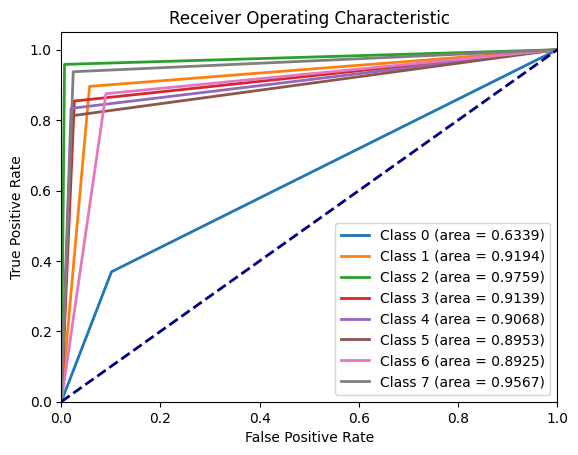

In [404]:
from pyod.models.xgbod import XGBOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest

# Assuming X and y are already defined
X_train = np.copy(X)
y_train = np.where(y == 0, 1, 0)

## Define and fit the model

# XGBOD
# ad = XGBOD(max_depth=15, learning_rate=0.029, n_estimators=199, gamma=0, silent=True, objective='binary:logitraw',
#            booster='gbtree', eval_metric='auc', min_child_weight=1, random_state=97, verbosity=0, tree_method='exact',
#            subsample=0.9, colsample_bytree=0.6)
# ad.fit(X_train, y_train)

# LOF
ad = LOF(n_neighbors=19, metric='cosine', contamination=0.16, algorithm="brute", novelty=True)
ad.fit(X_train)

# IF
# ad = IForest(n_estimators=200, max_samples='auto', contamination = 0.21, max_features=0.29, bootstrap=True,
#                                 behaviour='new', random_state=0, verbose=0)
# ad.fit(X_train, y_train)
# Predict
y_pred = ad.predict(final)
y_pred -= 1
y_pred = np.where(y_pred == -1, clf.predict(final)+1, y_pred)

# Evaluate performance
performance_metrics(y_blind, y_pred)

In [405]:
# from pyod.models.lof import LOF
# # X_selected_blind = feats_final[:, top_features_names]
# X_selected_blind = final[:, top_features_names]
# for i in range(0,1):

#     ad = XGBOD(max_depth = 10, learning_rate = 0.0007, n_estimators = 350, gamma = 0, silent=True, objective = 'binary:logitraw',
#               booster='gbtree', eval_metric = 'auc', min_child_weight = 1, random_state=62, verbosity = 0, tree_method = 'exact',
#               subsample = 0.4, colsample_bytree = 0.4)
#     ad.fit(X_selected, y_train)
#     y_pred = ad.predict(X_selected_blind)
#     y_pred -= 1
#     y_pred[y_pred<0]=1
#     print(i,":",accuracy_score(y_pred,y_cmp))

In [406]:
# from pyod.models.lof import LOF
# # X_selected_blind = feats_final[:, top_features_names]
# X_selected_blind = final[:, top_features_names]
# for i in range(30,70):
#     ad = LOF(n_neighbors=i, metric='cosine', contamination=0.415)
#     ad.fit(X_selected)
#     y_pred = ad.predict(X_selected_blind)
#     y_pred -= 1
#     y_pred[y_pred<0]=1
#     print(i,":",accuracy_score(y_pred,y_cmp))

In [407]:
# from pyod.models.lof import LOF
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# for i in range(30,100):
#     ad = LOF(n_neighbors=i, metric='cosine', contamination=0.4)
#     ad.fit(X)
#     y_pred = ad.predict(final)
#     y_pred -= 1
#     y_pred[y_pred<0]=1
#     print(i,":",accuracy_score(y_pred,y_cmp))

In [408]:
  # r = X_blind.shape[0]
# y_pred = []  # Initialize an empty list
# start_index = 720
# end_index = r
# n = 720
# # for i in range(start_index, end_index, 1):
# for i in range(r):
# # for i in range(n):
#     signal = X_blind[i,:]
#     feat = extract(signal)
#     print(i)
#     pred = ad.predict(feat)

#     if pred == 1:
#         y_pred = np.append(y_pred, 0)  # Assign the result back to y_pred
#     else:
#         #
#         # cl_pred = E_Anfis.predict(feat,bestParam,bestModel)
#         # cl_pred = np.round(cl_pred)
#         #
#         cl_pred = clf.predict(feat)
#         y_pred = np.append(y_pred, (cl_pred+1))  # Assign the result back to y_pred

# performance_metrics(y_blind,y_pred)